In [1]:
import pandas as pd
import numpy as np
from scipy.stats import trim_mean, kurtosis, skew, boxcox
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM, SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

import warnings
from time import perf_counter
import joblib

In [2]:
data = pd.read_csv("../../Data/Bank_Marketing.csv")
print("Few rows of the dataset")
data

Few rows of the dataset


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45203,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45204,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45205,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
print(f'The shape of Dataset:\nNumber of rows: {data.shape[0]}\nNumber of columns: {data.shape[1]}')

The shape of Dataset:
Number of rows: 45207
Number of columns: 17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45207 entries, 0 to 45206
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45207 non-null  int64 
 1   job        45207 non-null  object
 2   marital    45207 non-null  object
 3   education  45207 non-null  object
 4   default    45207 non-null  object
 5   balance    45207 non-null  int64 
 6   housing    45207 non-null  object
 7   loan       45207 non-null  object
 8   contact    45207 non-null  object
 9   day        45207 non-null  int64 
 10  month      45207 non-null  object
 11  duration   45207 non-null  int64 
 12  campaign   45207 non-null  int64 
 13  pdays      45207 non-null  int64 
 14  previous   45207 non-null  int64 
 15  poutcome   45207 non-null  object
 16  y          45207 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
print(f'Null values in each column:\n\n{data.isnull().sum()}')

Null values in each column:

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


<p style = "color:black"; "font-family:Times New Roman"
>The data.isnull() method indicates that this dataset has no <b>missing values</b>.
However, it is important to investigate <b>Unknown</b> values in different features.</p>

In [6]:
print("\nSummary statistics for numerical features:")
data.describe()


Summary statistics for numerical features:


,age,balance,day,duration,campaign,pdays,previous
count,45207.000000,45207.000000,45207.000000,45207.000000,45207.000000,45207.000000,45207.000000
mean,40.936315,1362.246798,15.806357,258.178202,2.763576,40.195656,0.574292
std,10.618940,3044.825898,8.322256,257.530264,3.097614,100.127179,1.907985
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,58.000000


<span style = "color:black">Insights from Dataset Description
The dataset description provides valuable insights into the distribution ans statistics of the numerical features:  
1. __Age:__
   * The mean age of clients is approximately 41 years.
   * The age of clients ranges from 18 to 95 years.
   * the majority of clients are between the age of 33 and 48.

2. __Balance:__
   * The mean account balance is approximately 1362 euros.
   * The account balance varies widely, ranging from -8019 to 102127 euros.
   * The distribution of account balances is skewed, with a large standard deviation of 3044,77.

3. __Day:__  
   * The mean last contact day of the month is approximately 16.

4. __Duration:__
   * The mean duration of the last contact is approximately 258 seconds.
   * The duration of the last contact ranges from 0 to 4918 seconds.
   * The distribution of contact duration is right-skewed, with a large standard deviation of 257.

5. __Campaign:__
   * The mean number of contacts performed during the current campaign is approximately 3.
   * The number of campaign contacts ranges from 1 to 63.

6. __Pdays (Number of days since the client was last contacted from a previous campaign):__  
   * The mean number of days since the client was last contacted is approximately 40 days.
   * A negative value (-1) indicates that the client was not previously contacted.

7. __Previous (Number of contacts performed before this campaign for the client):__
   * The number of previous contacts ranges from 0 to 275.
   * The majority of clients were not contacted before this campaign, as indicated by the 75th percentile.
</span>

In [7]:
#Selects all the columns that are of type numerical
num_col = data.select_dtypes(include=['int64']).columns

# Calculate mean and trimmed mean for each numeric columns
mean_vs_trimmed_mean = pd.DataFrame({'mean' : data[num_col].mean(),
                                    'trimmed_mean': data[num_col].
                                    apply(lambda x: trim_mean(x, proportiontocut=0.1))})

# Calculate kurtosis and skewness for each numeric columns
kurtosis_skewness = pd.DataFrame({'kurtosis': data[num_col].apply(kurtosis),
                                'skewness': data[num_col].apply(skew)})

print('Trimmed Mean vs Mean:')
mean_vs_trimmed_mean

Trimmed Mean vs Mean:


,mean,trimmed_mean
age,40.936315,40.251998
balance,1362.246798,767.225482
day,15.806357,15.687201
duration,258.178202,210.886775
campaign,2.763576,2.119805
pdays,40.195656,11.916913
previous,0.574292,0.129953


In [8]:
print("\nKurtosis and Skewness")
kurtosis_skewness


Kurtosis and Skewness


,kurtosis,skewness
age,0.319391,0.684781
balance,140.737422,8.360246
day,-1.059825,0.093124
duration,18.152035,3.144292
campaign,39.267417,4.899745
pdays,6.935489,2.615812
previous,110.845554,7.829590


### Insights

1. __Age:__

    The distribution of age is slightly right-skewed. The kurtosis values is close to 0, indicating a distribution that is close to normal.

2. __Balance:__

    The balance data is heavily right-skewed with a very high positive skewness (8.36) and positive kurtosis (140.74). This suggests that there are __many customers with a low balances__ and a __few customers with very high balance.__

3. __Duration:__

    The duration of the last contact is moderately rigth-skewed with a positive skewness of 3.14 and high positive kurtosis of 18.15. This indicates that there are some very long durations, potentially __outliers__, in the dataset.

4. __Campaign and Previous:__

    Both campaign and previous features have high positive skewness and kurtosis values, indicating __highly skewed distributions__ with heavy tails, potentially due to outliers.

In [9]:
print("\nSummary statistics for categorical features:")
data.describe(include='O')


Summary statistics for categorical features:


,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45207,45207,45207,45207,45207,45207,45207,45207,45207,45207
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27210,23200,44392,25127,37964,29282,13764,36956,39918


In [10]:
print(f'Unique values in each column:\n{data.nunique()}')

Unique values in each column:
age            77
job            12
marital         3
education       4
default         2
balance      7167
housing         2
loan            2
contact         3
day            31
month          12
duration     1572
campaign       48
pdays         559
previous       40
poutcome        4
y               2
dtype: int64


In [11]:
#Detecting if there are duplicate rows
data.duplicated().sum()

0

### Insights

+ There are no duplicate records in the dataset, indicating each entry is unique.
+ Also, we can see the most common value in each categorical feature.
+ According to the above results, we can conclude that:
    1. Married individuals are the most prevalent group in the dataset.
    2. A large portion of clients have completed secondary schooling.
    3. Most individuals did not subscribe to the service or product offered. This fact demonstrates that the label of this dataset is not balanced.

# Eda and Visualization 

## Categorical Features

In [12]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')

The __y__ column it's goint to be rename to subcrided due to clean coding

In [13]:
data.rename(columns={'y' : 'subscribed'}, inplace=True)

In [14]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
            'month', 'poutcome', 'subscribed']

for col in cat_cols:
    print(f"Percentage of each unique value in column '{col}':")
    value_counts = data[col].value_counts(normalize=True)*100
    value_counts = value_counts.round(2).astype(str) + '%'
    print(value_counts)
    print('='*50)
    print()

Percentage of each unique value in column 'job':
job
blue-collar       21.53%
management        20.92%
technician         16.8%
administrative    11.44%
services           9.19%
retired            5.01%
self-employed      3.49%
entrepreneur       3.29%
unemployed         2.88%
housemaid          2.74%
student            2.07%
unknown            0.64%
Name: proportion, dtype: object

Percentage of each unique value in column 'marital':
marital
married     60.19%
single      28.29%
divorced    11.52%
Name: proportion, dtype: object

Percentage of each unique value in column 'education':
education
secondary    51.32%
tertiary     29.42%
primary      15.15%
unknown       4.11%
Name: proportion, dtype: object

Percentage of each unique value in column 'default':
default
no     98.2%
yes     1.8%
Name: proportion, dtype: object

Percentage of each unique value in column 'housing':
housing
yes    55.58%
no     44.42%
Name: proportion, dtype: object

Percentage of each unique value in column '

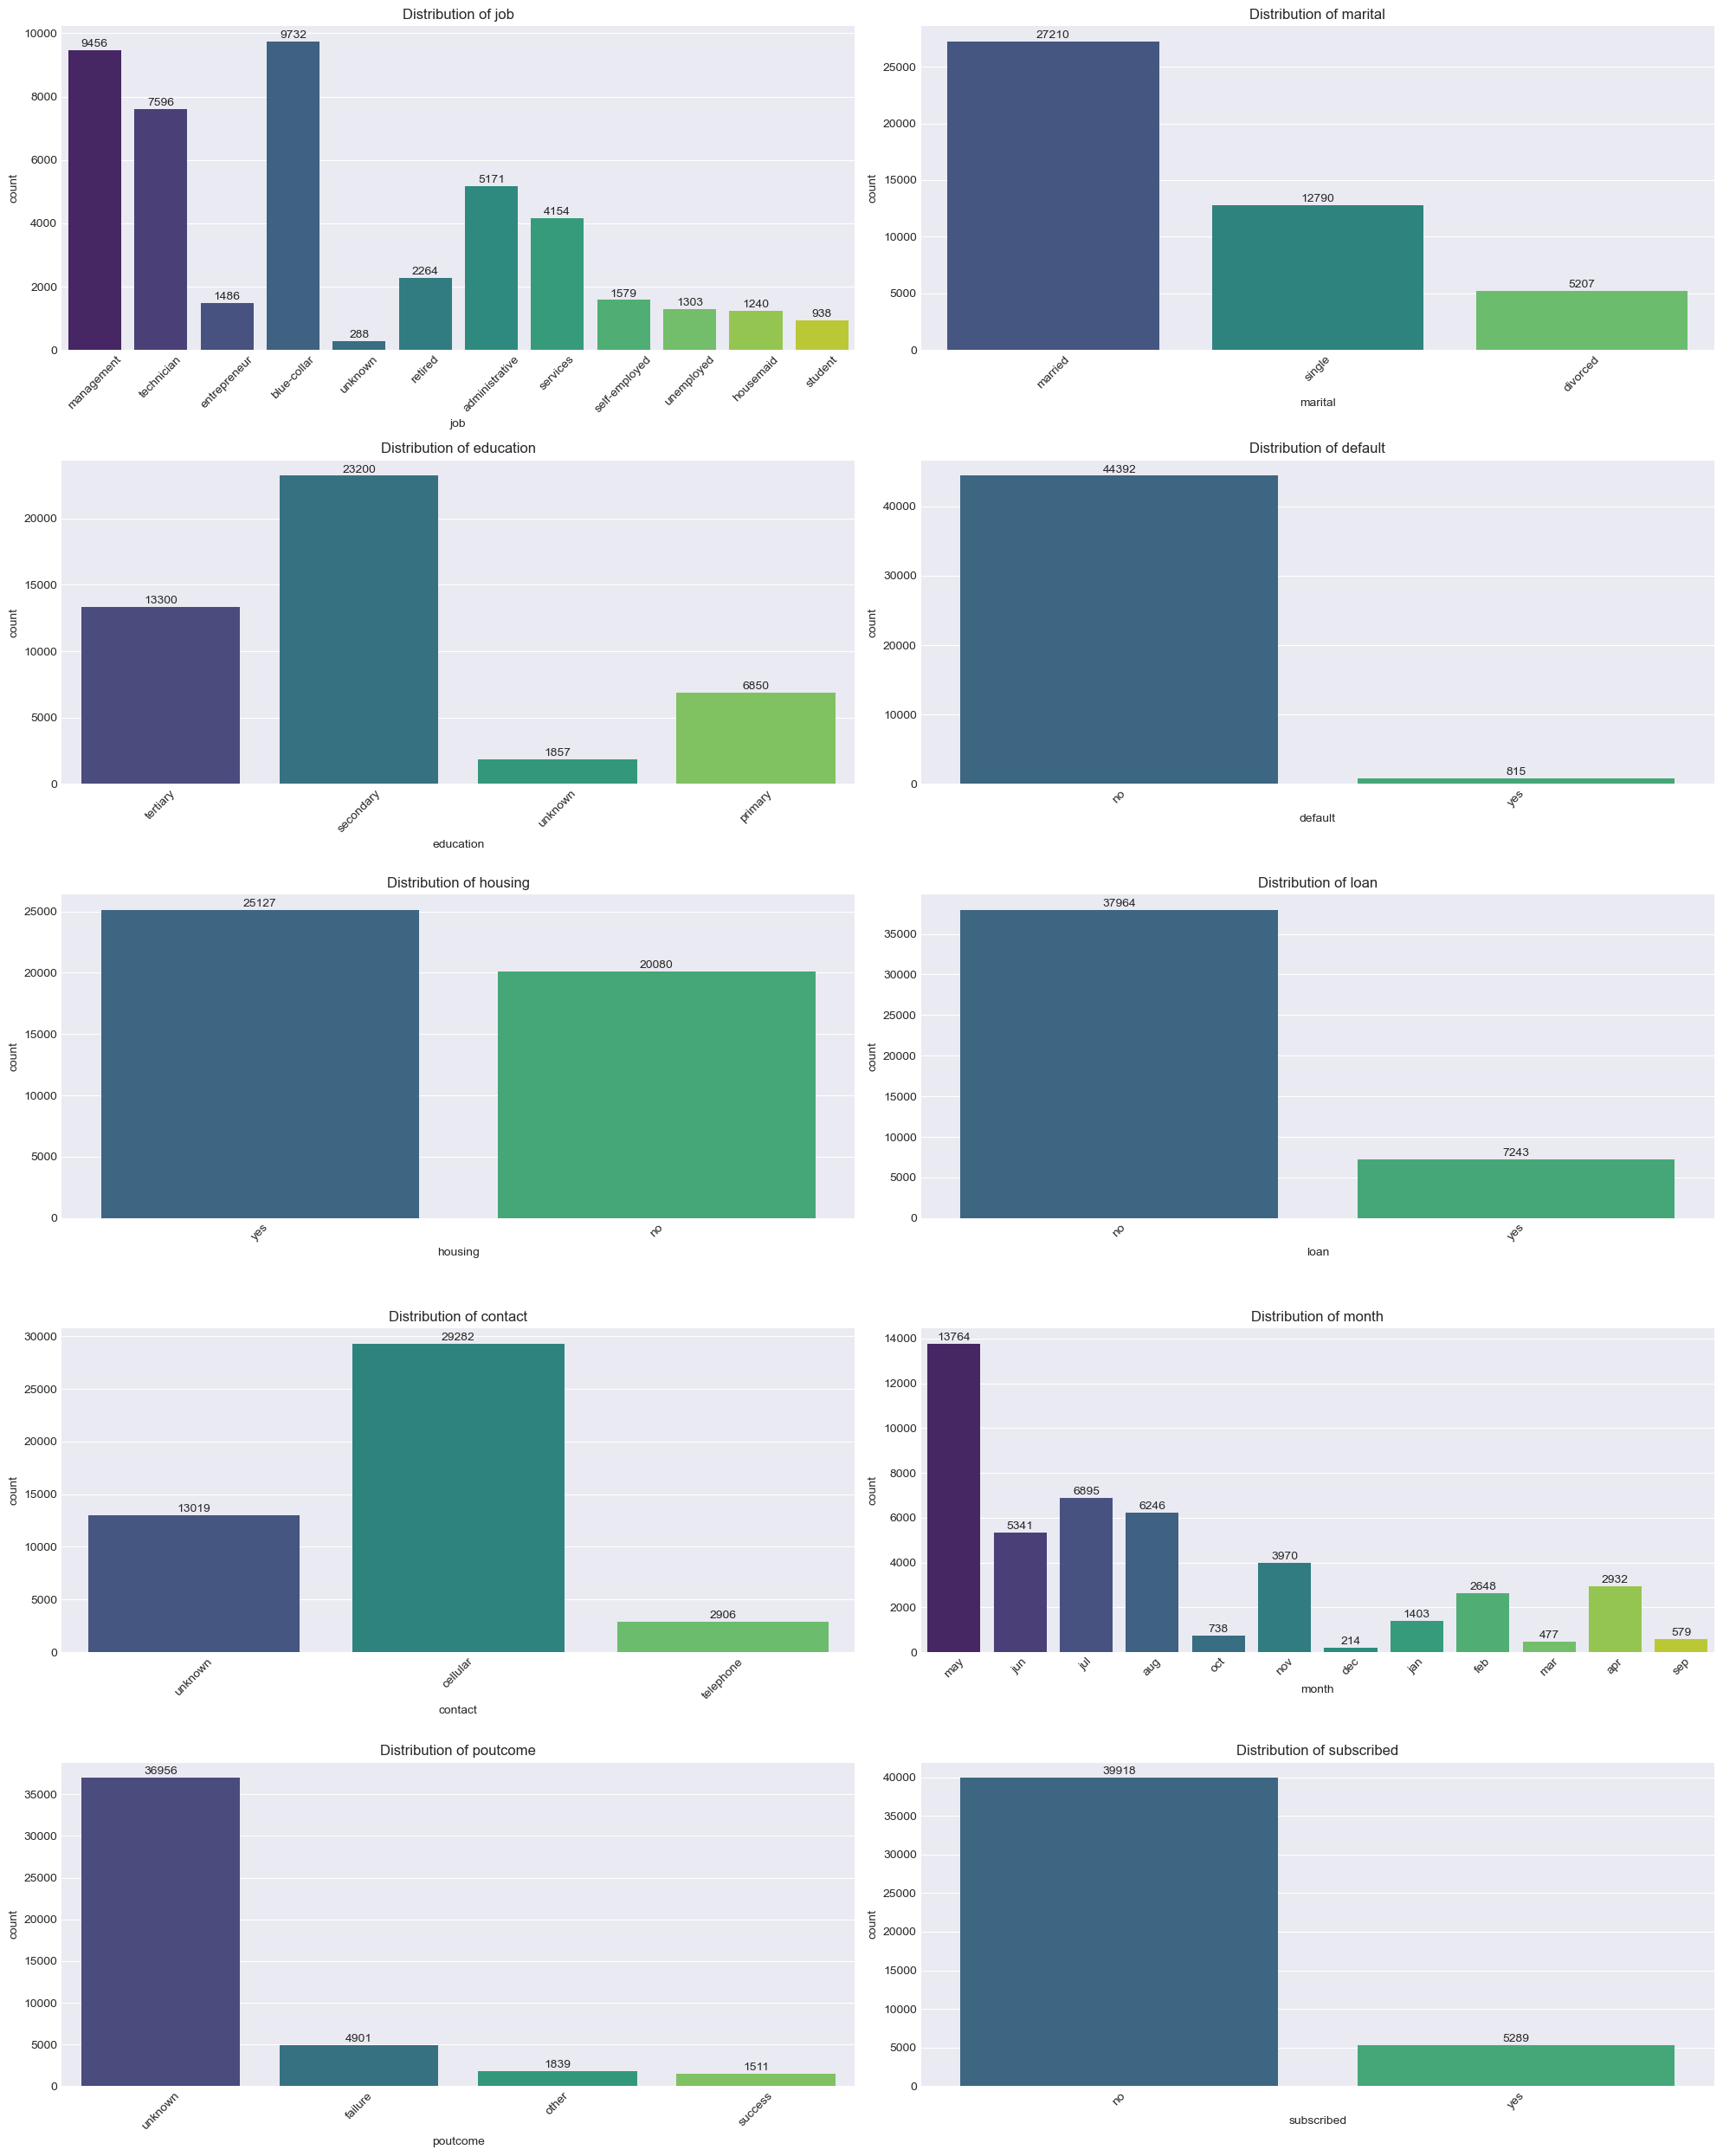

In [15]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(5, 2, figsize=(20,25))
ax = ax.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(
        x = col,
        data = data,
        ax = ax[i],
        palette='viridis'
    )
    ax[i].set_title(f'Distribution of {col}')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = 45)
    
    for p in ax[i].patches:
        ax[i].annotate(f'{int(p.get_height())}', 
                    (p.get_x()+p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    fontsize = 10,
                    xytext = (0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

__Inights__

* __Blue-collar__ and __management__ are the most common jobs in this dataset.
* The majority of clients have no credit in default.
* The most of contacts occured in may.
* Furthermore These results confirm that ground truth is __imbalanced__.
* We can see that __job, education, contact__, and __poutcome__ features have __unknown__ values. so, It is important to handle them before any other act on data.

## Handling Unknown Values

In [16]:
unknown_col = ['job', 'education', 'contact', 'poutcome']

for col in unknown_col:
    unknown_counter = data[col].eq('unknown').sum()
    print()
    print(f"Number of 'unknown' values in {col}: {unknown_counter}")
    print()


Number of 'unknown' values in job: 288


Number of 'unknown' values in education: 1857


Number of 'unknown' values in contact: 13019


Number of 'unknown' values in poutcome: 36956



Before handling unknown values, it's going to be determine the only rows where __'pdays'__ is -1 and __'previous'__ is 0, indicating that the client was not previously contacted. According to the dataset information, __unknown__ values of __poutcome__ column only present the clients who are in the __new campaign__. The following code snippet checks this case for us:

In [17]:
#Handling Unknown Values in 'poutcome'
#checking the clients just in the new campaign

new_camp = data[(data['pdays'] == -1) & (data['previous'] == 0)]
print('new campaign clients:', len(new_camp))

print()

# unkown values in 'poutcome'
print("unknown values in 'poutcome' column: ", len(data[data['poutcome'] == 'unknown']))

new campaign clients: 36951

unknown values in 'poutcome' column:  36956


__Insights__

Based on the information provided, there are indeed __5 null values__ in the __poutcome__ column. This is inferred from the fact that the number of rows where pdays is -1 (indicating clients not previously contacted) is __36951__, and the number of unknown values in the __poutcome__ column is __36956__.

In [18]:
# Replace 36951 occurrences of "unknown" with "Not Applicable"
data.loc[data['pdays'] == -1, 'poutcome'] = 'Not Applicable'

# Replace the other unknown values with np.nan in the dataset
data.replace('unknown', np.nan, inplace=True)

#Verify the changes
print(data['poutcome'].value_counts())
print()
print(data.isnull().sum())

poutcome
Not Applicable    36951
failure            4901
other              1839
success            1511
Name: count, dtype: int64

age               0
job             288
marital           0
education      1857
default           0
balance           0
housing           0
loan              0
contact       13019
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
poutcome          5
subscribed        0
dtype: int64


__A description of the following code:__

For imputing null values, __KNNImputer__ is an appropriate choice.

The KNNImputer requires numerical data for imputation, so we need to encode categorical variables into numerical format before using the imputer.

Including the target column ('subscribed' in this case) in the imputation process can lead to data leakage. This code ensures that the target column ('subscribed') is excluded from the imputation process.

To this end, this code first encodes the categorical variables into a numerical format using OrdinalEncoder, then performs imputation using KNNImputer, and finally converts the encoded columns back to their original categorical format using inverse_transform.

In [19]:
# Encode categorical variable into numerical format before imputation.
# Performe imputation.
# Concatenate the imputed data with the target column.

impute_data = data.iloc[:, :-1].copy()

columns_with_missing = ['job', 'education', 'contact', 'poutcome']

#Enconde categorical variable into numerical format.
encoder = OrdinalEncoder()
impute_data[columns_with_missing] = encoder.fit_transform(impute_data[columns_with_missing])

#KNN imputer
imputer = KNNImputer(n_neighbors=5)
impute_data[columns_with_missing] = imputer.fit_transform(impute_data[columns_with_missing])

# Convert enconded columns back to categorical format.
impute_data[columns_with_missing] = encoder.inverse_transform(impute_data[columns_with_missing])

# Concatenate the imputed data with the target column
impute_data['subscribed'] = data['subscribed']

print(impute_data.isnull().sum())


age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
subscribed    0
dtype: int64


comparison between the data set after and before the imputation.

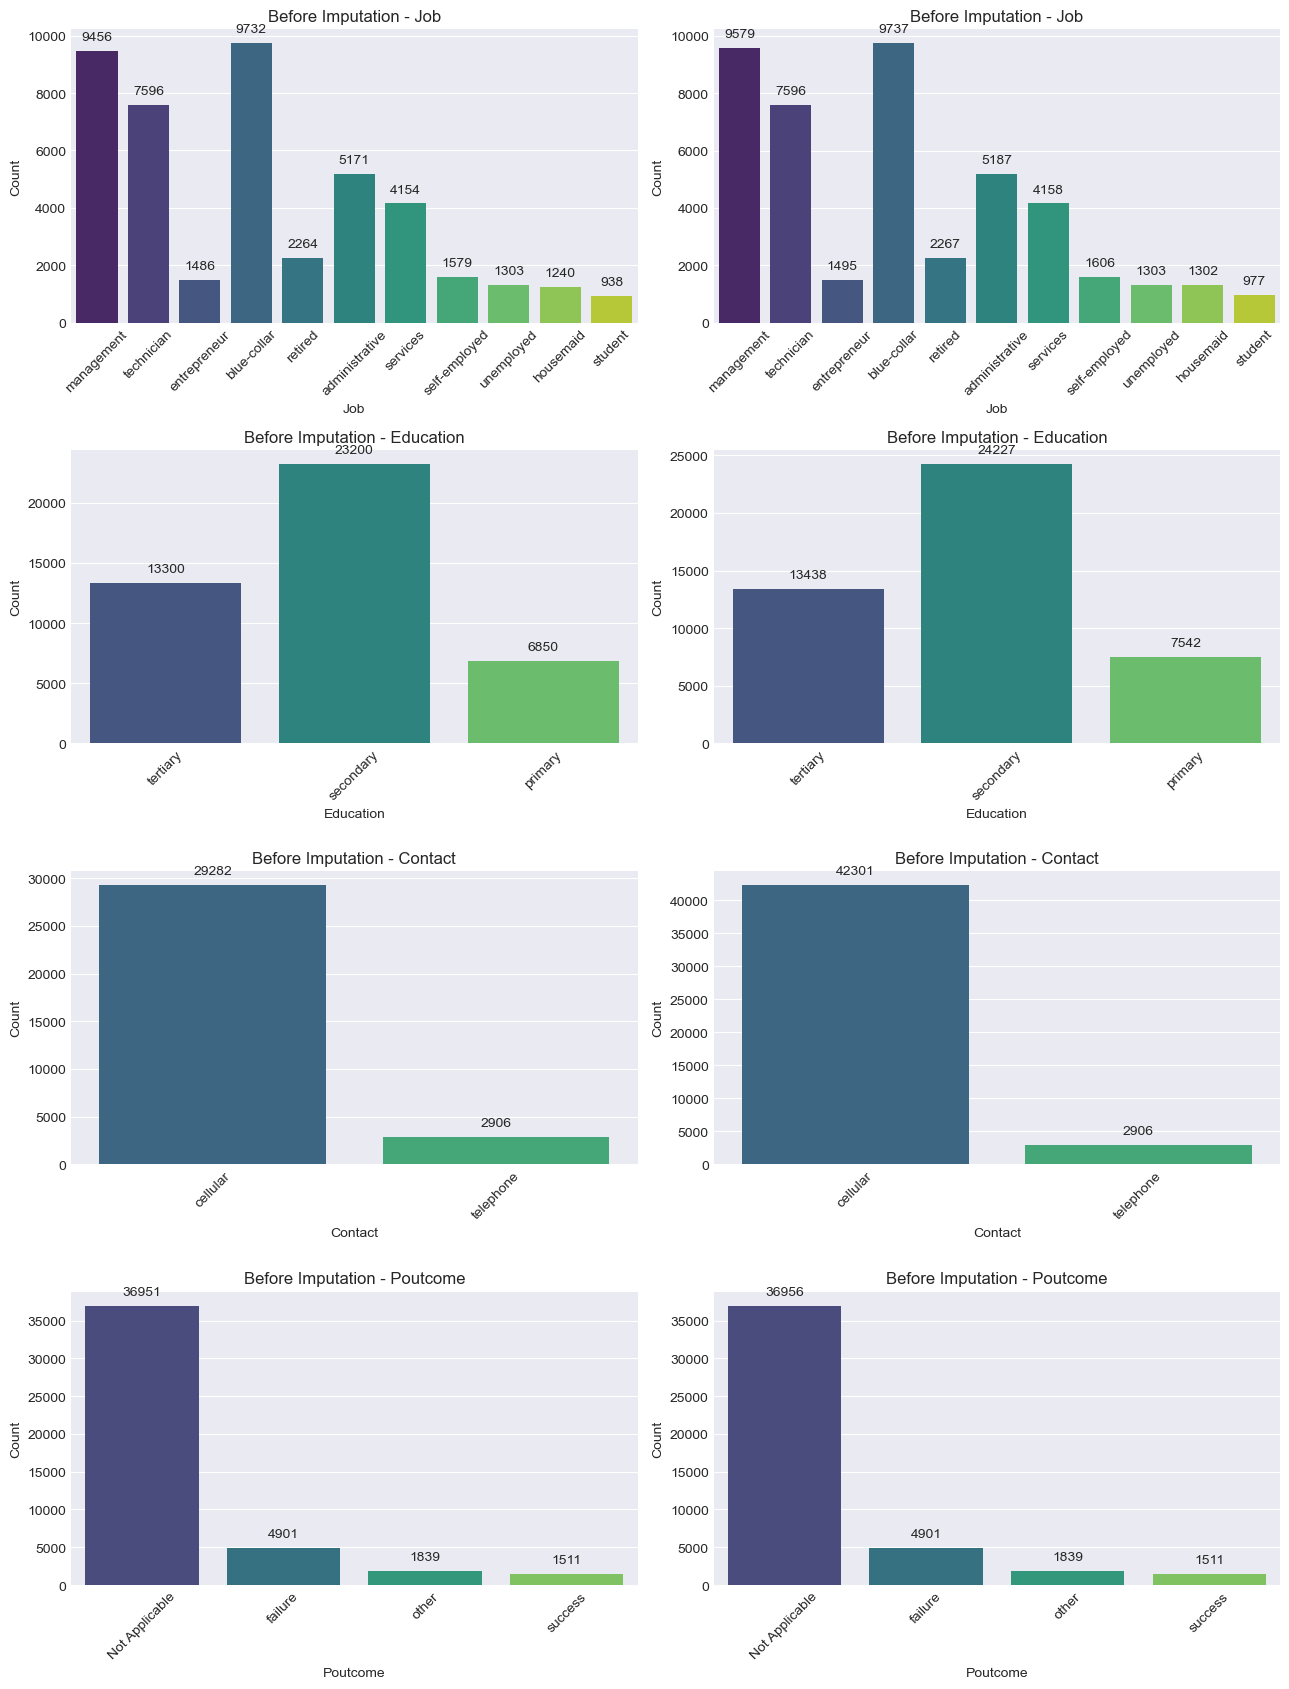

In [20]:
fig, ax = plt.subplots(4, 2, figsize = (13,17))

#Plot count plots before KNN imputation.
for i, column in enumerate(columns_with_missing):
    sns.countplot(x = column, data = data, ax = ax[i, 0], palette='viridis')
    ax[i, 0].set_title(f'Before Imputation - {column.capitalize()}')
    ax[i, 0].set_xticklabels(ax[i, 0].get_xticklabels(), rotation = 45)
    ax[i, 0].set_xlabel(column.capitalize())
    ax[i, 0].set_ylabel('Count')
    for p in ax[i, 0].patches:
        ax[i, 0].annotate(f'{int(p.get_height())}', (p.get_x()+p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext =(0, 10), textcoords = 'offset points' )

# Plot count plots after KNN imputation.
for i, column in enumerate(columns_with_missing):
    sns.countplot(x = column, data = impute_data, ax = ax[i, 1], palette='viridis')
    ax[i, 1].set_title(f'Before Imputation - {column.capitalize()}')
    ax[i, 1].set_xticklabels(ax[i, 1].get_xticklabels(), rotation = 45)
    ax[i, 1].set_xlabel(column.capitalize())
    ax[i, 1].set_ylabel('Count')
    for p in ax[i, 1].patches:
        ax[i, 1].annotate(f'{int(p.get_height())}', (p.get_x()+p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext =(0, 10), textcoords = 'offset points' )
        
plt.tight_layout()
plt.show()

### Insights

+ The majority of contacts are __cellular__ based.
+ __Failure__ is the most common status for poutcome.

# Numerical Features

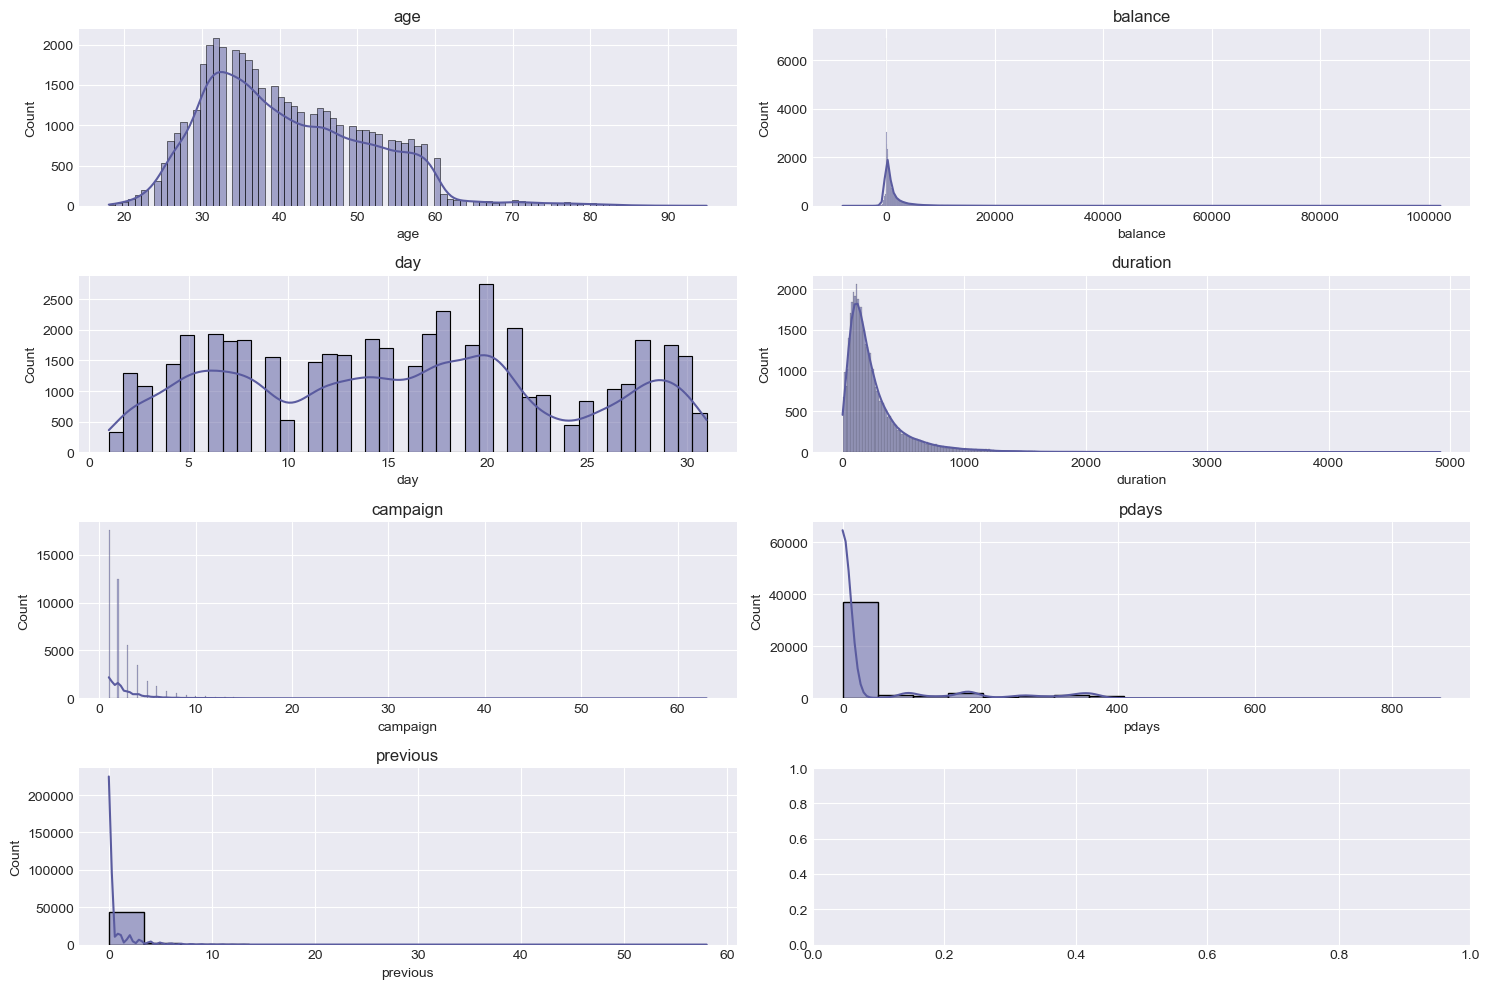

In [21]:
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(4, 2, figsize =  (15, 10))

index = 0
axs = axs.flatten()

for index, col in enumerate(impute_data.select_dtypes(include='number').columns):
    sns.histplot(impute_data[col], ax = axs[index], kde=True)
    axs[index].set_title(col)
    index +=1

plt.tight_layout()
plt.show()

### __Insights__

1. __Age__:

    As mentioned in the dataset overview section, this feature operates close to normal distribution.

2. __Balance Duration Campaign pdays and previous:__

    As we mentioned, this chart confirms that these features are right-skewed. So, we can see that there are some columns with very high values. As a result, we can conclude that these features have outliers.

3. __Day:__

    This feature operates like a uniform distribution. However, This chart demonstrates that the contacts during the 15th to 20th of the month are more than on other days.



# Age.

The following code snippet will categorize the age feature into specified age ranges and create a new categorical feature 'age category' based on these ranges.

In [22]:
#Define the number of desired categories.
num_cat = 8

#Use pd.cut to convert the 'age' column into categorical based on the specified number catehories.
impute_data['age_category'] = pd.cut(impute_data['age'], bins = num_cat)

#Display unique values in the age_category column
impute_data['age_category'].value_counts()

age_category
(27.625, 37.25]     17357
(37.25, 46.875]     11528
(46.875, 56.5]       9150
(56.5, 66.125]       3434
(17.923, 27.625]     3050
(66.125, 75.75]       427
(75.75, 85.375]       234
(85.375, 95.0]         27
Name: count, dtype: int64

In [23]:
#Define the category labels
category_labels = [
    '18-27 years',
    '28-37 years',
    '38-46 years',
    '47-56 years',
    '57-66 years',
    '67-75 years',
    '76-85 years',
    '86-95 years',
]

#Rename categories in the 'age_category' column

impute_data['age_category'] = impute_data['age_category'].cat.rename_categories(category_labels)

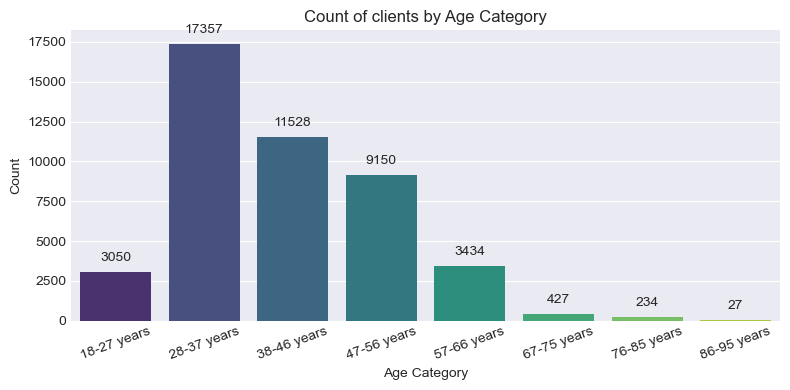

In [24]:
plt.figure(figsize=(8,4))
ax_3 = sns.countplot(x = 'age_category', data = impute_data, palette='viridis')
ax_3.set_xticklabels(ax_3.get_xticklabels(), rotation = 20)

for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2.,
                    p.get_height()),
                    ha = 'center', va = 'center', xytext = (0,10), textcoords = 'offset points')

plt.title('Count of clients by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

__Insights__

+ Between __28 and 46 years old__ is __64%__ of the population surveyed.

# pdays

Since -1 indicates no contact before the campaign, it can be treated as a separate category. For other values of __'pdays'__, we can use ranges similar to how we categorized the __'age'__ column.

In [25]:
# Define the bin edges for categorizing 'pdays'
pdays_bins = [-1, 0, 100, 200, 300, 400, 500, 600, 700, 800, np.inf]

# Define the category labels
pdays_labels = ['No contact in previous', '0-100 days', '101-200 days', '201-300 days', '301-400 days',
                '401-500 days', '501-600 days', '601-700 days', '701-800 days', 'More than 800 days']

# Use pd.cut to convert 'pdays' column into categorical based on the specified bins and labels
impute_data['pdays_category'] = pd.cut(impute_data['pdays'], bins = pdays_bins, labels = pdays_labels, right = False)

# Display unique values in the pdays_category column.
impute_data['pdays_category'].value_counts()

pdays_category
No contact in previous    36951
101-200 days               2879
301-400 days               2263
201-300 days               1473
0-100 days                 1407
401-500 days                127
501-600 days                 55
701-800 days                 22
601-700 days                 19
More than 800 days           11
Name: count, dtype: int64

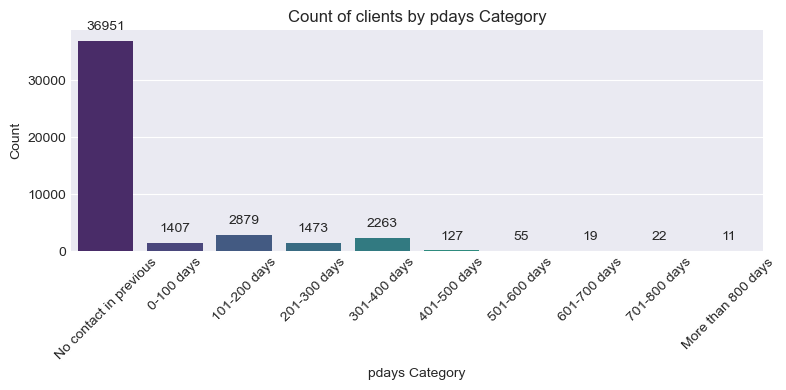

In [26]:
plt.figure(figsize=(8,4))
ax_4 = sns.countplot(x = 'pdays_category', data = impute_data, palette='viridis')
ax_4.set_xticklabels(ax_4.get_xticklabels(), rotation = 45)

for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2.,
                    p.get_height()),
                    ha = 'center', va = 'center', xytext = (0,10), textcoords = 'offset points')

plt.title('Count of clients by pdays Category')
plt.xlabel('pdays Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

__Insights__

+ This result confirms that the majority of the clients had no contacts in the previous campaign.
+ Customers with __pdays=101-200__ and __pdays=301-400__ are more numerous compared to the rest.

# Duration

In [27]:
# Define the number of desired categories
num_cat = 5

# Use pd.cut to convert the 'duration' column into categorical based on the specified number of categories
impute_data['duration_category'] = pd.cut(impute_data['duration'], bins = num_cat)

# Display unique values in the duration_category column
impute_data['duration_category'].value_counts()

duration_category
(-3.917, 984.4]     44108
(984.4, 1967.8]      1031
(1967.8, 2951.2]       54
(2951.2, 3934.6]       13
(3934.6, 4918.0]        1
Name: count, dtype: int64

In [28]:
# Define the bin edges for categorizing 'duration'
duration_bins = [0, 60, 180, 300, 600, 1800, np.inf]

# Define the category labels
duration_labels = ['0-1 min', '1-3 min', '3-5 min', '5-10 min', '10-30 min', 'More than 30 min']

# Use pd.cut to convert 'duration' column into categorical based on the specified bins and labels
impute_data['duration_category'] = pd.cut(impute_data['duration'], bins = duration_bins, labels = duration_labels, right = False)

# Display unique values in the duration_category column
impute_data['duration_category'].value_counts()

duration_category
1-3 min             17878
3-5 min             10345
5-10 min             8526
0-1 min              4656
10-30 min            3695
More than 30 min      107
Name: count, dtype: int64

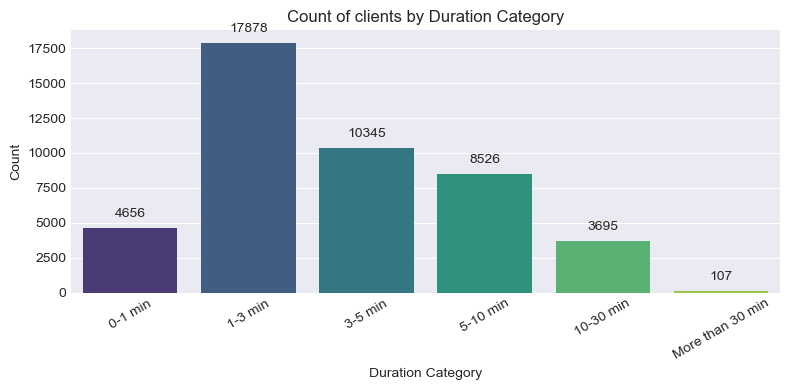

In [29]:
plt.figure(figsize=(8,4))
ax_5 = sns.countplot(x = 'duration_category', data = impute_data, palette='viridis')
ax_5.set_xticklabels(ax_5.get_xticklabels(), rotation = 30)

for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2.,
                    p.get_height()),
                    ha = 'center', va = 'center', xytext = (0,10), textcoords = 'offset points')

plt.title('Count of clients by Duration Category')
plt.xlabel('Duration Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

__Insights__

+ The contacts with __1 to 3 minutes__ duration are the most common in this dataset.

+ We can see that there are __107 contacts__ with more than 30 minutes. So, these contacts can be considered as outliers in the preprocessing phase.

# Multivariate Analysis

In [30]:
# Crosstab: Relationship between 'job' and 'subcribed' status
job_subscribed_crosstab = pd.crosstab(impute_data['job'], impute_data['subscribed'], normalize = 'index')
subscribed_job_crosstab = pd.crosstab(impute_data['subscribed'], impute_data['job'], normalize = 'index')

#Display the crosstab
print("Crosstab: Relationship between 'job' and 'subscribed' status")
print(job_subscribed_crosstab)
print("\n")
print(subscribed_job_crosstab)


Crosstab: Relationship between 'job' and 'subscribed' status
subscribed            no       yes
job                               
administrative  0.878157  0.121843
blue-collar     0.926877  0.073123
entrepreneur    0.917726  0.082274
housemaid       0.907834  0.092166
management      0.863869  0.136131
retired         0.771504  0.228496
self-employed   0.881694  0.118306
services        0.910534  0.089466
student         0.717503  0.282497
technician      0.889415  0.110585
unemployed      0.844973  0.155027


job         administrative  blue-collar  entrepreneur  housemaid  management  \
subscribed                                                                     
no                0.114109     0.226088      0.034370   0.029611    0.207300   
yes               0.119493     0.134619      0.023256   0.022689    0.246549   

job          retired  self-employed  services   student  technician  \
subscribed                                                            
no          0.04381

__Insights__
+ __'Student', 'retired', and 'management'__ have the highest proportion of subscribers (28.68%), (22.70%), and (13.67%), respectively, which could be due to factors such as financial stability ('retired') or lower financial commitments ('student').

+ On the other hand, __'blue-collar' and 'entrepreneur'__ have the lowest proportion of subscribers, which might be attributed to their lower income levels or different financial priorities.

+ So, if we target the __'Student', 'retired', and 'management'__ groups in marketing campaigns maybe we can get better results.

In [31]:
# Crosstab: Relationship between 'month' and 'subcribed' status
month_subscribed_crosstab = pd.crosstab(impute_data['month'], impute_data['subscribed'], normalize = 'index')

#Display the crosstab
print("Crosstab: Relationship between 'month' and 'subscribed' status")
print(month_subscribed_crosstab)

Crosstab: Relationship between 'month' and 'subscribed' status
subscribed        no       yes
month                         
apr         0.803206  0.196794
aug         0.889850  0.110150
dec         0.532710  0.467290
feb         0.833459  0.166541
jan         0.898788  0.101212
jul         0.909065  0.090935
jun         0.897772  0.102228
mar         0.480084  0.519916
may         0.932796  0.067204
nov         0.898489  0.101511
oct         0.562331  0.437669
sep         0.535406  0.464594


__Insights__

1. __Seasonal Trends in Subscription Behavior:__
    + Months like __'mar' (March), 'dec' (December), 'oct' (October), and 'sep' (September)__ have relatively higher proportions of subscribers compared to other months.
    + On the other hand, months like __'may', 'aug' (August), 'jul' (July), and 'nov' (November)__ have lower proportions of subscribers.
2. __Marketing Strategies and Seasonal Campaigns:__
    + Months with lower subscription rates may require more novel marketing strategies to increase subscription numbers.

In [32]:
# Crosstab: Relationship between 'age_category' and 'subcribed' status
age_category_subscribed_crosstab = pd.crosstab(impute_data['age_category'], impute_data['subscribed'], normalize = 'index')
subscribed_age_category_crosstab = pd.crosstab(impute_data['subscribed'], impute_data['age_category'], normalize = 'index')

#Display the crosstab
print("Crosstab: Relationship between 'age_category' and 'subscribed' status")
print(age_category_subscribed_crosstab)
print('\n')
print(subscribed_age_category_crosstab)

Crosstab: Relationship between 'age_category' and 'subscribed' status
subscribed          no       yes
age_category                    
18-27 years   0.804918  0.195082
28-37 years   0.887135  0.112865
38-46 years   0.908570  0.091430
47-56 years   0.907869  0.092131
57-66 years   0.842167  0.157833
67-75 years   0.580796  0.419204
76-85 years   0.559829  0.440171
86-95 years   0.481481  0.518519


age_category  18-27 years  28-37 years  38-46 years  47-56 years  57-66 years  \
subscribed                                                                      
no               0.061501     0.385741     0.262388     0.208102     0.072449   
yes              0.112498     0.370391     0.199282     0.159387     0.102477   

age_category  67-75 years  76-85 years  86-95 years  
subscribed                                           
no               0.006213     0.003282     0.000326  
yes              0.033844     0.019474     0.002647  


__Insights__

+ The age category __'86-95 years'__ stands out with the highest subscription rate, while the youngest category has a relatively lower rate.
+ __Older age__ categories generally exhibit higher subscription rates compared to __younger age__ categories.

In [33]:
# Crosstab: Relationship between 'pdays_category' and 'subcribed' status
pdays_category_subscribed_crosstab = pd.crosstab(impute_data['pdays_category'], impute_data['subscribed'], normalize = 'index')
subscribed_pdays_category_crosstab = pd.crosstab(impute_data['subscribed'], impute_data['pdays_category'], normalize = 'index')

#Display the crosstab
print("Crosstab: Relationship between 'pdays_category' and 'subscribed' status")
print(pdays_category_subscribed_crosstab)
print('\n')
print(subscribed_pdays_category_crosstab)



Crosstab: Relationship between 'pdays_category' and 'subscribed' status
subscribed                    no       yes
pdays_category                            
No contact in previous  0.908419  0.091581
0-100 days              0.565032  0.434968
101-200 days            0.739493  0.260507
201-300 days            0.866259  0.133741
301-400 days            0.897923  0.102077
401-500 days            0.440945  0.559055
501-600 days            0.545455  0.454545
601-700 days            0.684211  0.315789
701-800 days            0.636364  0.363636
More than 800 days      0.545455  0.454545


pdays_category  No contact in previous  0-100 days  101-200 days  \
subscribed                                                         
no                            0.840899    0.019916      0.053334   
yes                           0.639818    0.115712      0.141804   

pdays_category  201-300 days  301-400 days  401-500 days  501-600 days  \
subscribed                                                     

__Insights__

+ Customers with __'No contact in previous campaigns'__ have a relatively lower subscription rate (9.16%) compared to those with contact in previous campaigns.
+ Customers with recent contacts __(e.g., '0-100 days', '101-200 days')__ tend to have higher subscription rates compared to those with no recent contact.
+ Subscription rates vary across different ranges of days since the last contact. For example, customers with __'More than 800 days'__ since the last contact have a higher subscription rate.
+ According to these results, targeting customers with __previous contacts__ may lead to higher subscription rates.

In [34]:
# Crosstab: Relationship between 'pdays_category' and 'subcribed' status
duration_category_subscribed_crosstab = pd.crosstab(impute_data['duration_category'], impute_data['subscribed'], normalize = 'index')
subscribed_duration_category_crosstab = pd.crosstab(impute_data['subscribed'], impute_data['duration_category'], normalize = 'index')

#Display the crosstab
print("Crosstab: Relationship between 'duration_category' and 'subscribed' status")
print(duration_category_subscribed_crosstab)
print('\n')
print(subscribed_duration_category_crosstab)

Crosstab: Relationship between 'duration_category' and 'subscribed' status
subscribed               no       yes
duration_category                    
0-1 min            0.998067  0.001933
1-3 min            0.961293  0.038707
3-5 min            0.891638  0.108362
5-10 min           0.808820  0.191180
10-30 min          0.517727  0.482273
More than 30 min   0.485981  0.514019


duration_category   0-1 min   1-3 min   3-5 min  5-10 min  10-30 min  \
subscribed                                                             
no                 0.116414  0.430533  0.231074  0.172754   0.047923   
yes                0.001702  0.130838  0.211949  0.308187   0.336926   

duration_category  More than 30 min  
subscribed                           
no                         0.001303  
yes                        0.010399  


__Insights__

Customers __with longer contact durations__ exhibit higher subscription rates compared to shorter durations.

In [35]:
def plot_countplot_with_annotations(data, x_col, hue_col):
    """
    Funtion to create a countplot with annotations.
    
    Parameters:
    - data: DataFrame containing the data
    - x_col: Column to be plotted on x-axis
    - hue_col: Column to be used for coloring (hue)
    
    Returns:
    -None (displays the plot)
    """
    
    # Plot countplot
    plt.figure(figsize=(8, 4))
    ax = sns.countplot(x = x_col, hue = hue_col, data = data)
    
    # Add annotations
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',(p.get_x()+p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', fontsize = 10, xytext = (0, 5),
                    textcoords = 'offset points')
    
    #Set labels and title
    plt.xlabel(x_col.capitalize())
    plt.ylabel('Count')
    plt.title(f'Count of Subscriptions by {x_col.capitalize()} Status')
    
    plt.show()

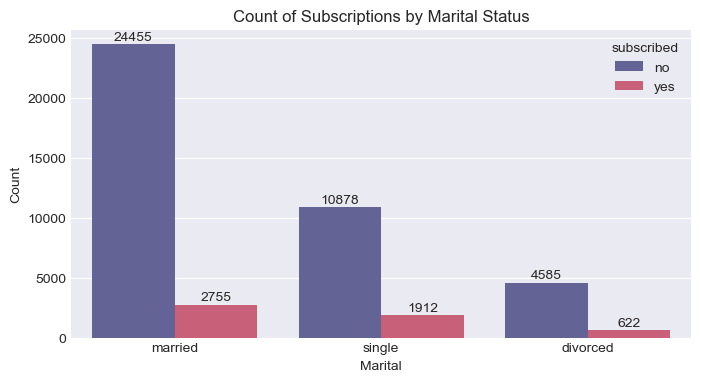

In [36]:
plot_countplot_with_annotations(impute_data, 'marital', 'subscribed')

__Insights__

+ Married individuals have the highest count of both subscribers and non-subscribers, suggesting they constitute a significant portion of the dataset.

+ Single individuals have a comparatively higher proportion of subscribers relative to their count, indicating potential effectiveness in targeting this demographic for subscription-based services.

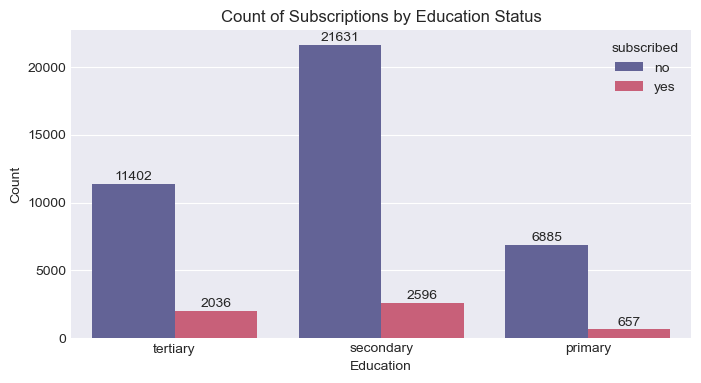

In [37]:
plot_countplot_with_annotations(impute_data, 'education', 'subscribed')

__Insights__

+ Customers with __secondary education constitute the largest group__ in both subscribers and non-subscribers.

+ While __tertiary-educated individuals have a higher proportion of subscribers relative to their count__, indicating potential effectiveness in targeting this demographic for subscription-based services.

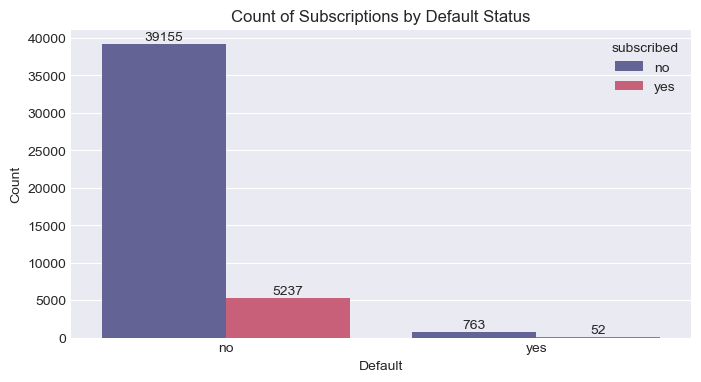

In [38]:
plot_countplot_with_annotations(impute_data, 'default', 'subscribed')

__Insights__

+ Customers __without a default status__ constitute the vast majority of both subscribers and non-subscribers.
+ The number of subscribers among customers with a default status is very low, indicating potential challenges or barriers to subscription among this group.

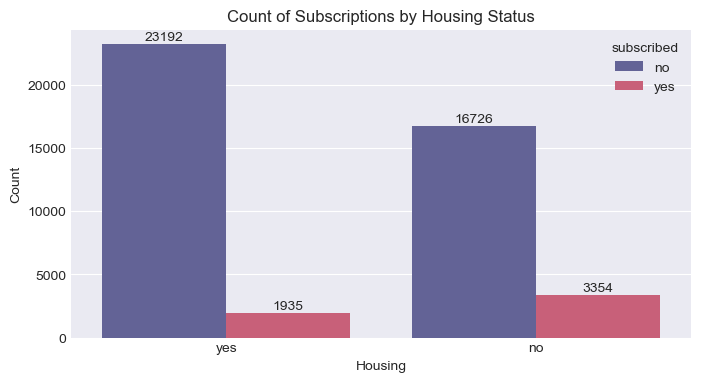

In [39]:
plot_countplot_with_annotations(impute_data, 'housing', 'subscribed')

__Insights__

+ Customers __without a housing loan__ constitute a larger portion of subscribers, suggesting __they might be more inclined to subscribe__ to the term deposit.
+ However, the count of non-subscribers is higher among customers with a housing loan.

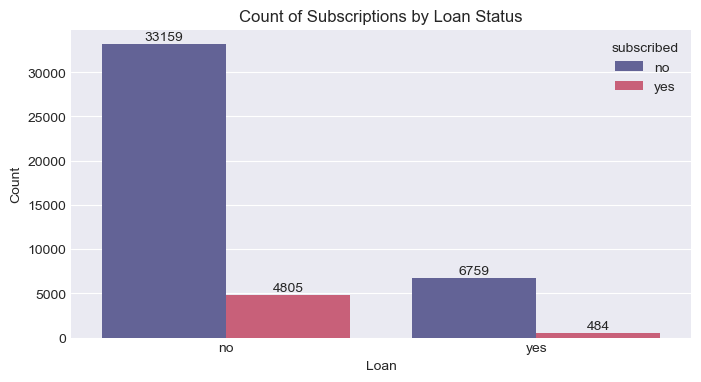

In [40]:
plot_countplot_with_annotations(impute_data, 'loan', 'subscribed')

__Insights__

+ Customers __without a personal loan__ constitute a larger portion of subscribers, suggesting they might be more inclined to subscribe to the term deposit.
+ However, the count of non-subscribers is higher among customers with a personal loan, indicating __potential differences in subscription behavior__ based on personal loan status.

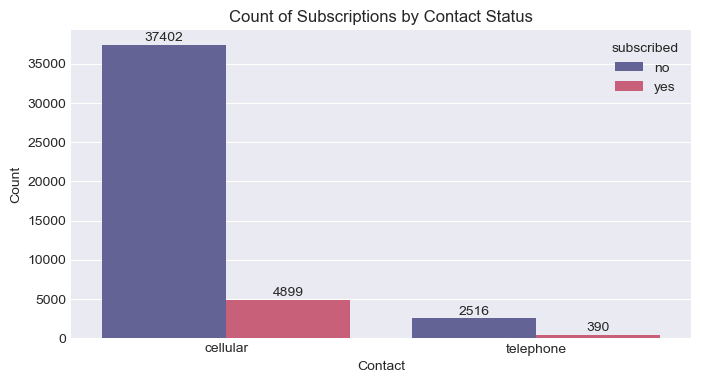

In [41]:
plot_countplot_with_annotations(impute_data, 'contact', 'subscribed')

__Insights__

+ Customers contacted via __cellular__ communication constitute a larger portion of subscribers, suggesting __they might be more responsive to this communication channel__.
+ However, the count of non-subscribers is higher among customers contacted via cellular communication, indicating potential differences in subscription behavior based on the communication type.

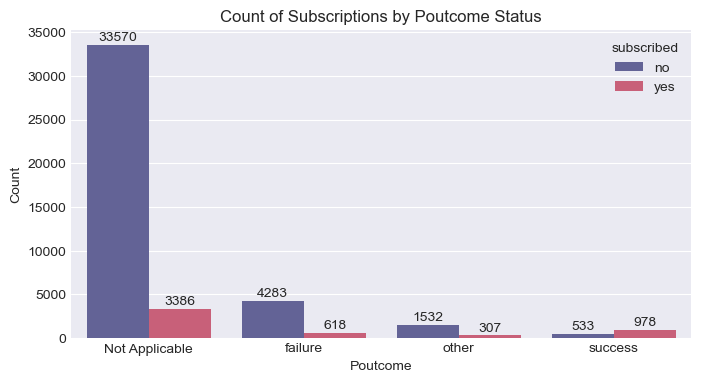

In [42]:
plot_countplot_with_annotations(impute_data, 'poutcome', 'subscribed')

__Insights__

+ Clients with successful outcomes in the previous campaign show a higher propensity to subscribe to the term deposit.
+ The largest count of non-subscribers is observed among clients categorized as 'Not Applicable', indicating that previous campaign success greatly influences subscription rates in the current campaign.

In [43]:
# Create pivot table with trimmed mean.
pivot_result = impute_data.pivot_table(
    ['age', 'day', 'balance'],
    ['subscribed'],
    aggfunc = lambda x: trim_mean(x, proportiontocut=0.1)
)

print("Pivot Table")
print(pivot_result)

Pivot Table
                  age      balance        day
subscribed                                   
no          40.252442   719.558836  15.780342
yes         40.362627  1149.399953  14.948972


__Insights__

1. __Relationship between Age and Subscription Status:__
    + There's a subtle difference in the average age between subscribers and non-subscribers, suggesting age may not be a strong predictor of subscription status.

2. __Relationship between Balance and Subscription Status:__
    + This indicates that customers with higher average balances are more likely to subscribe to the term deposit.

3. __Relationship between Day and Subscription Status:__
    + This suggests that subscribers were contacted earlier in the month compared to non-subscribers, although the difference is relatively small.

In [44]:
#Define columns for groupby
#This is other form to calculate the trim mean, but makes the same like the past block.
groupby_columns = ['duration', 'campaign', 'previous']

#Using groupby
groupby_result = impute_data.groupby('subscribed')[groupby_columns].agg(
    lambda x: trim_mean(x, 0.1)
)

#Display the result
print("Groupby: ")
print(groupby_result)

Groupby: 
              duration  campaign  previous
subscribed                                
no          186.625814  2.176415  0.079252
yes         481.424522  1.751240  0.603118


__Insights__

1. __Relationship between Duration and Subscription Status:__
    + This suggests that longer contact duration tends to be associated with a higher likelihood of subscription.
2. __Relationship between Campaign and Subscription Status:__
    + This indicates that subscribers tend to require fewer contact attempts through campaigns before subscribing.
3. __Relationship between Previous Contacts and Subscription Status:__
    + This confirms that subscribers tend to have more previous contacts compared to non-subscribers, indicating potentially higher engagement or interest in the term deposit.

In [47]:
#Define columns for groupby
groupby_columns = ['job', 'subscribed']
numerical_columns = ['balance', 'duration', 'campaign']

# Using groupby
groupby_result = impute_data.groupby(groupby_columns)[numerical_columns].agg(lambda x: trim_mean(x, 0.1))

#Display the results
print('Groupby:')
print(groupby_result)


Groupby:
                               balance    duration  campaign
job            subscribed                                   
administrative no           619.908093  182.200549  1.997531
               yes          940.918972  441.187747  1.622530
blue-collar    no           623.938097  196.368647  2.182108
               yes          840.531579  632.687719  1.812281
entrepreneur   no           691.052823  189.514572  2.215847
               yes         1078.949495  603.222222  2.121212
housemaid      no           752.945032  175.118393  2.300211
               yes         1160.395833  497.770833  1.916667
management     no           923.906208  178.143030  2.275185
               yes         1428.187739  443.184866  1.841954
retired        no          1060.575303  197.403283  2.012848
               yes         1708.819712  411.668269  1.552885
self-employed  no           849.428571  187.118166  2.275132
               yes         1256.559211  514.125000  1.677632
services       

__Insights:__

* Non-subscribers generally have lower average balances, shorter contact durations, and higher campaign numbers compared to subscribers.

* Subscribers tend to have higher average balances, longer contact durations, and lower campaign numbers compared to non-subscribers.

* Notable differences are observed between non-subscribers and subscribers within specific job categories. For example, subscribers in administrative roles exhibit significantly higher average balances and longer contact durations compared to non-subscribers in the same category.

* This trend holds across diverse job categories, indicating a consistent pattern of behavior regarding balance, duration, and campaign engagement between non-subscribers and subscribers.

In [48]:
# Define columns for groupby
numerical_columns = ['balance', 'duration', 'campaign']

# Using groupby
groupby_result = impute_data.groupby(['education', 'subscribed'])[numerical_columns].agg(lambda x: trim_mean(x, 0.1))

# Display the results
print('Groupby:')
print(groupby_result)

Groupby:
                          balance    duration  campaign
education subscribed                                   
primary   no           693.552913  185.458341  2.229987
          yes         1217.017078  573.956357  1.865275
secondary no           636.284484  190.606125  2.130483
          yes          983.767084  494.795958  1.679981
tertiary  no           918.588577  179.776584  2.234050
          yes         1363.680368  435.358282  1.806135


__Insights:__

* This result again confirms that Non-subscribers generally have lower average balances, shorter contact durations, and higher campaign numbers than subscribers.

* Notable differences are observed between non-subscribers and subscribers within each education level. For example, subscribers with primary education exhibit significantly higher average balances and longer contact durations compared to non-subscribers with primary education.
* Similar patterns are observed across different education levels, indicating consistent behavior regarding balance, duration, and campaign engagement between non-subscribers and subscribers, regardless of education level.

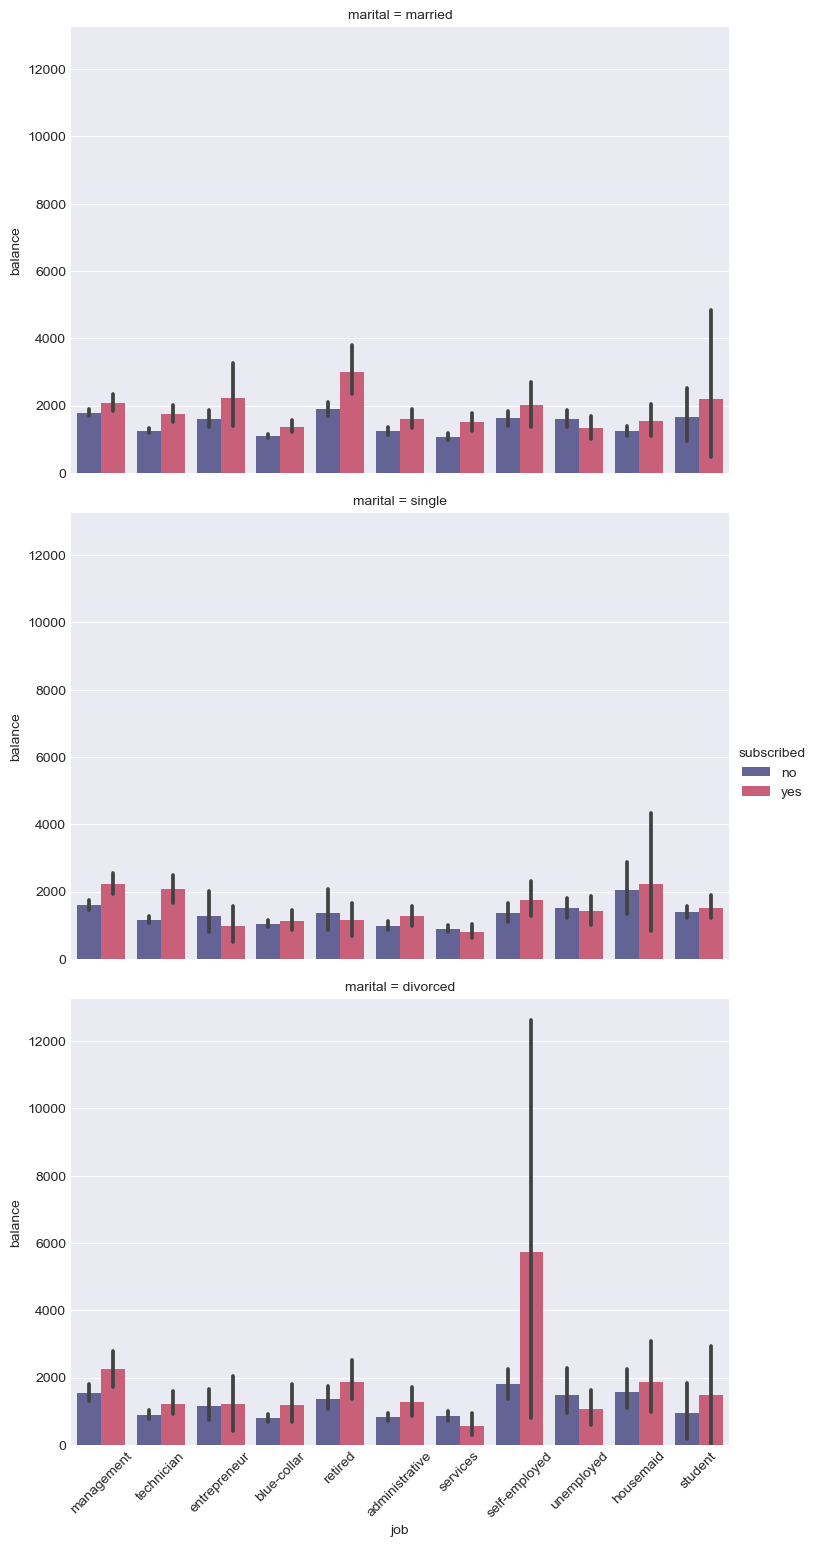

In [57]:
# col_wrap define the numbers of graphics per column
axs = sns.catplot(
    data = impute_data,
    x = 'job',
    y = 'balance',
    hue = 'subscribed',
    kind = 'bar',
    col = 'marital',
    col_wrap = 1,
    aspect = 1.5
)

axs.tick_params(axis = 'x', labelrotation = 45)


__Insights:__

* These results confirm our hypothesis that subscribers generally have higher balances compared to the Non-subscribers.

* Furthermore, in the divorced status, there are notable differences in balance between Non-subscribers and subscribers. For example, balance values in the 'self-employed' job have a very wide range.

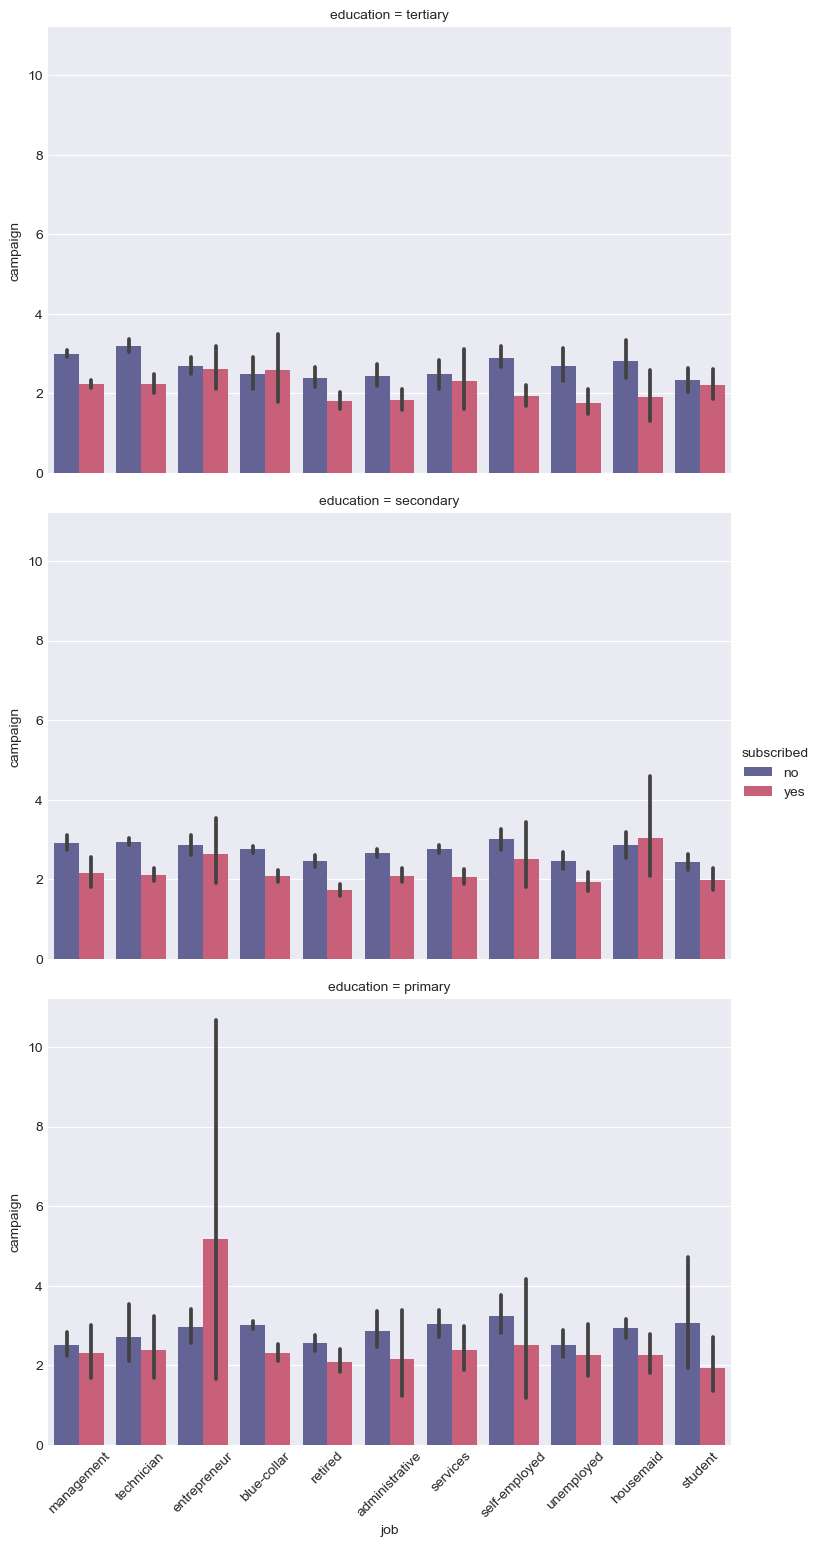

In [59]:
axs = sns.catplot(
    data = impute_data,
    x = 'job',
    y = 'campaign',
    hue = 'subscribed',
    kind = 'bar',
    col = 'education',
    col_wrap = 1,
    aspect = 1.5
)

axs.tick_params(axis = 'x', labelrotation = 45)

__Insights:__

* These results confirm our hypothesis that clients generally need lower contacts to subscribe to a term deposit.

* This fact perfectly aligns with the tertiary education level. However, for secondary and primary education levels, respectively for the two occupations of housemaid and entrepreneur, it is not true, and these two jobs require more contact to encourage subscription.

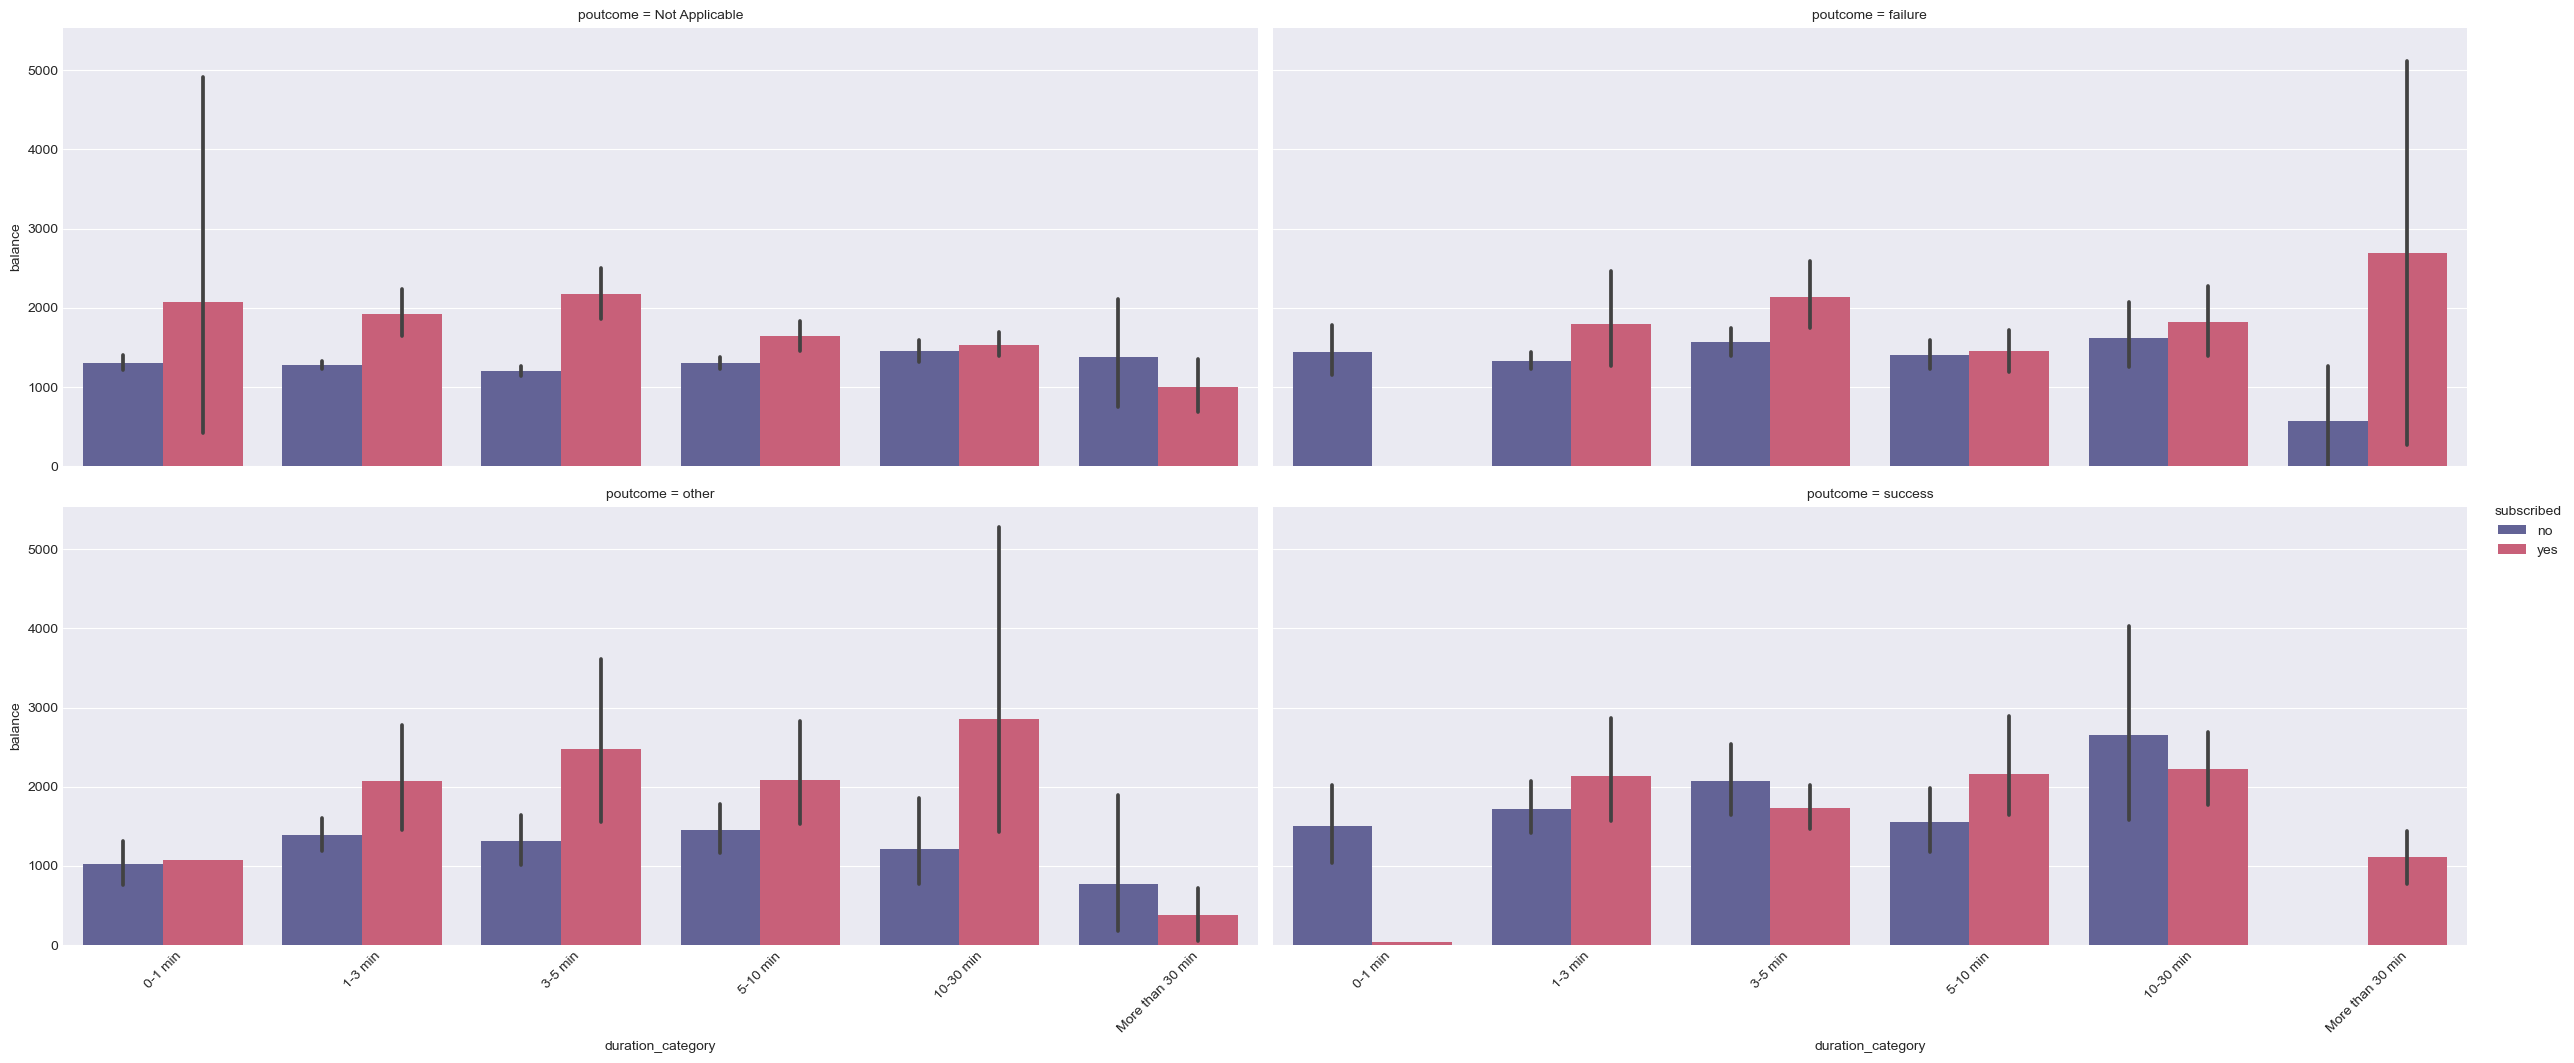

In [61]:
axs = sns.catplot(
    data = impute_data,
    x = 'duration_category',
    y = 'balance',
    hue = 'subscribed',
    kind = 'bar',
    col = 'poutcome',
    col_wrap = 2,
    aspect = 2.5
)

axs.tick_params(axis = 'x', labelrotation = 45)

__Insights:__

* In the previous visualization, we see that subscribers have a higher balance. This chart also confirms this fact. while giving us some other information.

* For example, for new clients and clients with 'poutcome=other', the balance value of subscribers in more than 30 minutes (duration) is lower than for Non-subscribers. However, this result indicates that a duration of more than 30 minutes can be considered an outlier due to the contrary behavior of the majority of the population.

* Clients with failure and success status in poutcome almost decided to not subscribe if their duration is 0-1 min. This fact shows that clients with previous contacts require better strategies instead of short contact during a new campaign.

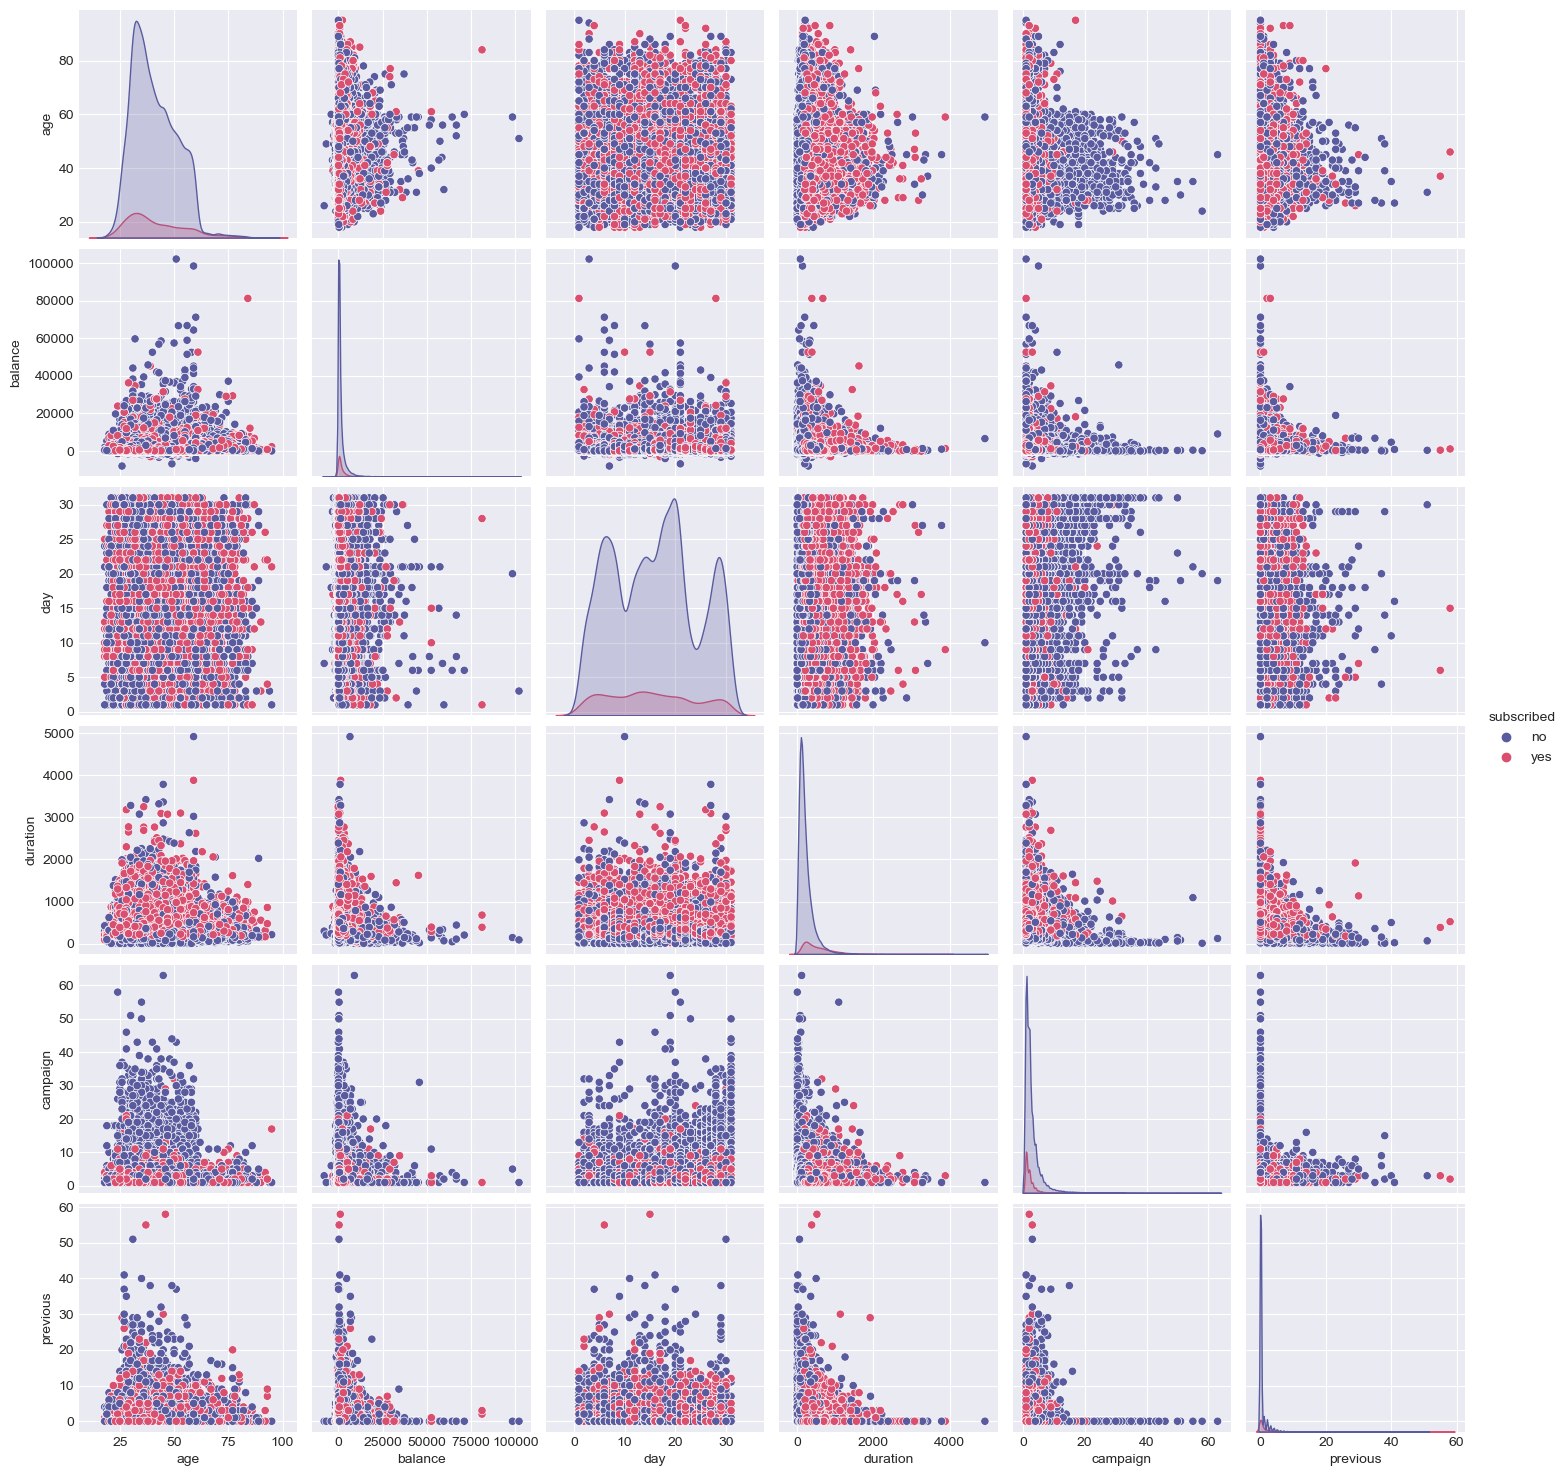

In [62]:
sns.pairplot(
    impute_data,
    x_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'previous'],
    y_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'previous'],
    hue = 'subscribed'
)